<h1 align=center><font size = 7>Capstone Project - The Battle of the Neighbourhoods</font></h1> 

<h1 align=center><font size = 7>"Dress to Impress"</font></h1> 

<h2 align=center><font size = 5>Applied Data Science Capstone by IBM</font></h2>

## Table of Contents:

1.  <a href="#item1">Business Problem</a>

2.  <a href="#item2">Data</a>

3.  <a href="#item3">Analysis</a>



<a id='item1'></a>
## Business Problem

Andreea is a vlogger moving to Bucharest, Romania, to follow her dream of opening her own coffee shop. She currently makes her living out of her Youtube and Instagram accounts, making movies about her whereabouts. She is looking to find out which neighbourhood from Bucharest is the most suitable to fit her highly active lifestyle. The neighbourhood should lack too many coffee shops, so that it could embrace her own business. Doing so, she hopes to maximize her chances of success.

The target audience for this project should also be other self-employed people looking for fame and cash-flow generated by their presence in certain places, in the city of Bucharest. Also, people looking to invest in consumer-oriented business should find this study helpful in decided where and why to invest in certain places. 

<a id='item2'></a>
## Data

Based on definition of our problem, factors that will influence our decision are:
- diversity of neighbourhood amenities
- closeness of similar neighbourhoods
- number of existing coffee shops in the neighbourhood

The data used for this report are sourced using the following:
- Wikipedia page to identify all Neighbourhoods in Bucharest, Romania: https://en.wikipedia.org/wiki/Category:Districts_of_Bucharest
- Foursquare API to find amenities and their type and location in every neighbourhood from Bucharest
- Google Maps API geocoding to locate the neighbourhoods


<a id='item3'></a>
## Analysis

In [1]:
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import requests
!pip install lxml 
!pip install folium
import folium
from sklearn.cluster import KMeans
import random
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

     |████████████████████████████████| 94 kB 4.8 MB/s  eta 0:00:01


### Importing Neighbourhoods in Bucharest from Wikipedia using BeautifulSoup

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Districts_of_Bucharest').text 
soup = BeautifulSoup(source, 'lxml')

In [3]:
csv_file = open('bucharest.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

15

In [4]:
mwcg = soup.find_all(class_ = "mw-category-group")
length = len(mwcg) 
for i in range(1, length): 
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title')
        csv_writer.writerow([nbd])

In [5]:
csv_file.close()

In [12]:
df = pd.read_csv('bucharest.csv')

In [13]:
df.shape

(39, 1)

In [14]:
df.head(10)

Neighbourhood
0    Băneasa, Bucharest
1    Berceni, Bucharest
2        Bucureștii Noi
3         Centrul Civic
4  Colentina, Bucharest
5             Cotroceni
6              Crângași
7             Dămăroaia
8         Dealul Spirii
9             Dorobanți

In [16]:
df['Neighbourhood'] = df.Neighbourhood.str.replace(', Bucharest,?' , '')

In [17]:
df.head(10)

Neighbourhood
0         Băneasa
1         Berceni
2  Bucureștii Noi
3   Centrul Civic
4       Colentina
5       Cotroceni
6        Crângași
7       Dămăroaia
8   Dealul Spirii
9       Dorobanți

### Adding Latitude and Longitude using Google Geocode API

In [19]:
# The code was removed by Watson Studio for sharing.

In [23]:
import requests
import json


latitudes = []
longitudes = []
distance = []

for nbd in df["Neighbourhood"] : 
    address = nbd + ", Bucharest,Romania"
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address, google_api_key)
    obj = json.loads(requests.get(url).text)
    
    results = obj['results']
    lat = results[0]['geometry']['location']['lat']
    lng = results[0]['geometry']['location']['lng']

    latitudes.append(lat)
    longitudes.append(lng)


In [24]:
df['Latitude'] = latitudes
df['Longitude'] = longitudes

In [25]:
df.head(10)

Neighbourhood   Latitude  Longitude
0         Băneasa  44.493726  26.076048
1         Berceni  44.389221  26.118203
2  Bucureștii Noi  44.493619  26.031081
3   Centrul Civic  44.427285  26.092441
4       Colentina  44.465766  26.148647
5       Cotroceni  44.429874  26.070091
6        Crângași  44.455002  26.047913
7       Dămăroaia  44.491447  26.060160
8   Dealul Spirii  44.428385  26.085606
9       Dorobanți  44.459076  26.096738

### Map of Bucharest's Neighbourhoods

In [115]:
from geopy.geocoders import Nominatim
address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [116]:
map_bucharest = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

### Using Foursquare to get the venues from Bucharest

In [208]:
# The code was removed by Watson Studio for sharing.

In [333]:
def getNearbyVenues(names, latitudes, longitudes, radius=300):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
   
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [334]:
bucharest_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Băneasa
Berceni
Bucureștii Noi
Centrul Civic
Colentina
Cotroceni
Crângași
Dămăroaia
Dealul Spirii
Dorobanți
Dristor
Drumul Taberei
Dudești
Ferentari
Floreasca
Fundeni
Ghencea
Giulești
Grivița
Iancului
Lipscani
Militari
Moșilor
Obor
Odăi
Olteniței
Pantelimon
Pipera
Primăverii
Progresul
Rahova
Regie
Tineretului
13 Septembrie
Giurgiului
Tei
Titan
Văcărești
Vitan


In [337]:
print(bucharest_venues.shape)
bucharest_venues.head()

(308, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0       Băneasa               44.493726                26.076048   
1       Băneasa               44.493726                26.076048   
2       Băneasa               44.493726                26.076048   
3       Băneasa               44.493726                26.076048   
4       Băneasa               44.493726                26.076048   

                  Venue  Venue Latitude  Venue Longitude    Venue Category  
0  Pizzeria Capricciosa       44.495738        26.077086       Pizza Place  
1                La Jar       44.495109        26.078031  Theme Restaurant  
2       Pasajul Băneasa       44.494556        26.079360            Tunnel  
3              Părculeț       44.494508        26.076944              Park  
4              La Boeru       44.493170        26.078858        Restaurant

In [338]:
bucharest_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  Neighbourhood Longitude  Venue  \
Neighbourhood                                                            
13 Septembrie                        5                        5      5   
Berceni                              5                        5      5   
Bucureștii Noi                       4                        4      4   
Băneasa                              8                        8      8   
Centrul Civic                        9                        9      9   
Colentina                            6                        6      6   
Cotroceni                            7                        7      7   
Crângași                             9                        9      9   
Dealul Spirii                        3                        3      3   
Dorobanți                           30                       30     30   
Dristor                             12                       12     12   
Drumul Taberei                       8                        8      8   
Dudești                             15                       15     15   
Dămăroaia                            1                        1      1   
Ferentari                            4                        4      4   
Floreasca                            7                        7      7   
Fundeni                              3                        3      3   
Ghencea                              6                        6      6   
Giulești                             8                        8      8   
Giurgiului                           7                        7      7   
Iancului                            13                       13     13   
Lipscani                            30                       30     30   
Militari                             4                        4      4   
Moșilor                             11                       11     11   
Obor                                13                       13     13   
Odăi                                 1                        1      1   
Olteniței                           11                       11     11   
Pantelimon                           4                        4      4   
Primăverii                          12                       12     12   
Regie                               18                       18     18   
Tei                                  5                        5      5   
Tineretului                         10                       10     10   
Titan                                2                        2      2   
Vitan                                5                        5      5   
Văcărești                           12                       12     12   

                Venue Latitude  Venue Longitude  Venue Category  
Neighbourhood                                                    
13 Septembrie                5                5               5  
Berceni                      5                5               5  
Bucureștii Noi               4                4               4  
Băneasa                      8                8               8  
Centrul Civic                9                9               9  
Colentina                    6                6               6  
Cotroceni                    7                7               7  
Crângași                     9                9               9  
Dealul Spirii                3                3               3  
Dorobanți                   30               30              30  
Dristor                     12               12              12  
Drumul Taberei               8                8               8  
Dudești                     15               15              15  
Dămăroaia                    1                1               1  
Ferentari                    4                4               4  
Floreasca                    7                7               7  
Fundeni                      3                3               3  
Ghencea                

In [339]:
bc_venues=bucharest_venues.Neighbourhood.value_counts()
bc_venues

Lipscani          30
Dorobanți         30
Regie             18
Dudești           15
Iancului          13
Obor              13
Văcărești         12
Dristor           12
Primăverii        12
Olteniței         11
Moșilor           11
Tineretului       10
Crângași           9
Centrul Civic      9
Giulești           8
Drumul Taberei     8
Băneasa            8
Giurgiului         7
Cotroceni          7
Floreasca          7
Colentina          6
Ghencea            6
Tei                5
13 Septembrie      5
Berceni            5
Vitan              5
Militari           4
Bucureștii Noi     4
Ferentari          4
Pantelimon         4
Fundeni            3
Dealul Spirii      3
Titan              2
Dămăroaia          1
Odăi               1
Name: Neighbourhood, dtype: int64

In [340]:
import matplotlib as mpl
import matplotlib.pyplot as plt

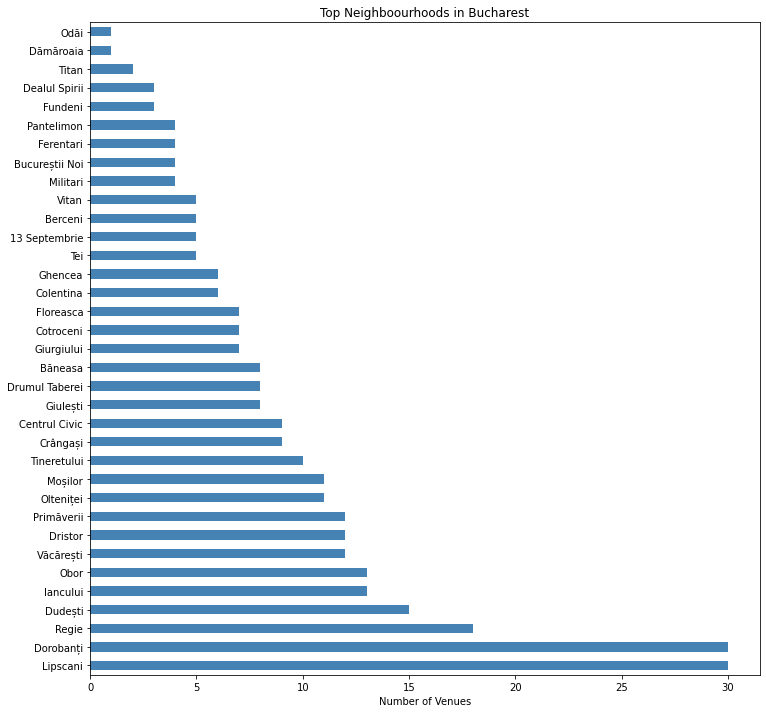

In [341]:
bc_venues.plot(kind='barh', figsize=(12, 12), color='steelblue')
plt.xlabel('Number of Venues')
plt.title('Top Neighboourhoods in Bucharest')
plt.show()

In [342]:
bucharest_venues.groupby(['Neighbourhood'])['Venue Category'].value_counts(normalize=True)

Neighbourhood  Venue Category              
13 Septembrie  Department Store                0.200000
               Indian Restaurant               0.200000
               Pizza Place                     0.200000
               Plaza                           0.200000
               Romanian Restaurant             0.200000
                                                 ...   
Văcărești      Pizza Place                     0.083333
               Pool                            0.083333
               Soccer Field                    0.083333
               Tennis Stadium                  0.083333
               Theme Park Ride / Attraction    0.083333
Name: Venue Category, Length: 273, dtype: float64

In [344]:
print('There are {} uniques categories.'.format(len(bucharest_venues['Venue Category'].unique())))

There are 110 uniques categories.


### Analyzing each Neighbourhood

In [345]:

bucharest_onehot = pd.concat([bucharest_venues['Neighbourhood'],pd.get_dummies(bucharest_venues['Venue Category'])], axis=1)
print(bucharest_onehot.shape)
bucharest_onehot.head()


(308, 111)


Neighbourhood  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0       Băneasa           0                    0                 0   
1       Băneasa           0                    0                 0   
2       Băneasa           0                    0                 0   
3       Băneasa           0                    0                 0   
4       Băneasa           0                    0                 0   

   Athletics & Sports  Auto Dealership  BBQ Joint  Bagel Shop  Bakery  Bar  \
0                   0                0          0           0       0    0   
1                   0                0          0           0       0    0   
2                   0                0          0           0       0    0   
3                   0                0          0           0       0    0   
4                   0                0          0           0       0    0   

   ...  Taco Place  Tea Room  Tennis Stadium  Theater  Theme Park  \
0  ...           0         0               0        0           0   
1  ...           0         0               0        0           0   
2  ...           0         0               0        0           0   
3  ...           0         0               0        0           0   
4  ...           0         0               0        0           0   

   Theme Park Ride / Attraction  Theme Restaurant  Tunnel  \
0                             0                 0       0   
1                             0                 1       0   
2                             0                 0       1   
3                             0                 0       0   
4                             0                 0       0   

   Vegetarian / Vegan Restaurant  Wine Bar  
0                              0         0  
1                              0         0  
2                              0         0  
3                              0         0  
4                              0         0  

[5 rows x 111 columns]

In [346]:
bucharest_grouped = bucharest_onehot.groupby('Neighbourhood').mean().reset_index()
bucharest_grouped

Neighbourhood  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0    13 Septembrie    0.000000             0.000000          0.000000   
1          Berceni    0.000000             0.000000          0.000000   
2   Bucureștii Noi    0.000000             0.000000          0.000000   
3          Băneasa    0.000000             0.000000          0.000000   
4    Centrul Civic    0.000000             0.000000          0.000000   
5        Colentina    0.000000             0.000000          0.000000   
6        Cotroceni    0.000000             0.000000          0.000000   
7         Crângași    0.000000             0.000000          0.000000   
8    Dealul Spirii    0.333333             0.000000          0.000000   
9        Dorobanți    0.000000             0.000000          0.033333   
10         Dristor    0.000000             0.000000          0.000000   
11  Drumul Taberei    0.000000             0.000000          0.000000   
12         Dudești    0.000000             0.000000          0.000000   
13       Dămăroaia    0.000000             0.000000          0.000000   
14       Ferentari    0.000000             0.000000          0.000000   
15       Floreasca    0.000000             0.000000          0.000000   
16         Fundeni    0.000000             0.000000          0.000000   
17         Ghencea    0.000000             0.000000          0.000000   
18        Giulești    0.000000             0.000000          0.000000   
19      Giurgiului    0.000000             0.000000          0.000000   
20        Iancului    0.000000             0.076923          0.000000   
21        Lipscani    0.000000             0.000000          0.000000   
22        Militari    0.000000             0.000000          0.000000   
23         Moșilor    0.000000             0.000000          0.000000   
24            Obor    0.000000             0.000000          0.000000   
25            Odăi    0.000000             0.000000          0.000000   
26       Olteniței    0.000000             0.000000          0.000000   
27      Pantelimon    0.000000             0.000000          0.000000   
28      Primăverii    0.000000             0.000000          0.000000   
29           Regie    0.000000             0.000000          0.000000   
30             Tei    0.000000             0.000000          0.000000   
31     Tineretului    0.000000             0.000000          0.000000   
32           Titan    0.000000             0.000000          0.000000   
33           Vitan    0.000000             0.000000          0.000000   
34       Văcărești    0.000000             0.000000          0.000000   

    Athletics & Sports  Auto Dealership  BBQ Joint  Bagel Shop    Bakery  \
0             0.000000              0.0   0.000000    0.000000  0.000000   
1             0.000000              0.0   0.000000    0.000000  0.200000   
2             0.000000              0.0   0.000000    0.000000  0.250000   
3             0.000000              0.0   0.000000    0.000000  0.125000   
4             0.000000              0.0   0.000000    0.000000  0.000000   
5             0.000000              0.0   0.000000    0.000000  0.000000   
6             0.000000              0.0   0.000000    0.000000  0.000000   
7             0.000000              0.0   0.000000    0.000000  0.000000   
8             0.000000              0.0   0.000000    0.000000  0.000000   
9             0.000000              0.0   0.000000    0.000000  0.066667   
10            0.000000              0.0   0.000000    0.000000  0.000000   
11            0.000000              0.0   0.000000    0.000000  0.000000   
12            0.000000              0.0   0.000000    0.000000  0.000000   
13            0.000000              0.0   0.000000    0.000000  0.000000   
14            0.000000              0.0   0.000000    0.000000  0.000000   
15            0.000000              0.0   0.000000    0.000000  0.000000   
16            0.000000              0.0   0.000000    0.000000  0.000000   
17      

### Top Neighbourhood/venue

In [347]:
num_top_venues = 1

for hood in bucharest_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = bucharest_grouped[bucharest_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----13 Septembrie----
               venue  freq
0  Indian Restaurant   0.2


----Berceni----
                 venue  freq
0  Lebanese Restaurant   0.2


----Bucureștii Noi----
          venue  freq
0  Dessert Shop  0.25


----Băneasa----
  venue  freq
0  Café  0.25


----Centrul Civic----
        venue  freq
0  Restaurant  0.22


----Colentina----
                 venue  freq
0  Rental Car Location  0.17


----Cotroceni----
    venue  freq
0  Market  0.14


----Crângași----
           venue  freq
0  Grocery Store  0.22


----Dealul Spirii----
        venue  freq
0  Art Museum  0.33


----Dorobanți----
  venue  freq
0  Café   0.1


----Dristor----
         venue  freq
0  Supermarket  0.25


----Drumul Taberei----
        venue  freq
0  Restaurant  0.25


----Dudești----
  venue  freq
0  Café   0.2


----Dămăroaia----
         venue  freq
0  Supermarket   1.0


----Ferentari----
  venue  freq
0  Park  0.25


----Floreasca----
  venue  freq
0  Pool  0.29


----Fundeni----
        venue  

### Putting into Pandas framework

In [348]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [349]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = bucharest_grouped['Neighbourhood']

for ind in np.arange(bucharest_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bucharest_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0   13 Septembrie   Romanian Restaurant     Indian Restaurant   
1         Berceni                   Pub   Lebanese Restaurant   
2  Bucureștii Noi          Dessert Shop                   Gym   
3         Băneasa                  Café            Restaurant   
4   Centrul Civic            Restaurant               Theater   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0                 Plaza           Pizza Place      Department Store  
1                Bakery           Cheese Shop              Fountain  
2                Bakery           Supermarket   Fried Chicken Joint  
3                Tunnel      Theme Restaurant           Pizza Place  
4   Romanian Restaurant        Clothing Store        Chocolate Shop

### Cluster Neighbourhoods

In [350]:
kclusters = 5
bucharest_grouped_clustering = bucharest_grouped.drop('Neighbourhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bucharest_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [351]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bucharest_merged = df

bucharest_merged = bucharest_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')


In [393]:
bucharest_merged.tail()

Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
34    Giurgiului  44.389770  26.093142             0.0            Playground   
35           Tei  44.459806  26.118913             0.0            Restaurant   
36         Titan  44.420545  26.158415             0.0            Restaurant   
37     Văcărești  44.404109  26.114987             0.0    Italian Restaurant   
38         Vitan  44.410508  26.129060             0.0        Cosmetics Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
34           Pizza Place        Sandwich Place     Electronics Store   
35      Doner Restaurant    Italian Restaurant     Electronics Store   
36                  Park           IT Services          Dessert Shop   
37                  Pool              Gym Pool          Soccer Field   
38       Auto Dealership     Electronics Store         Metro Station   

           5th Most Common Venue  
34                   Supermarket  
35                           Bar  
36              Doner Restaurant  
37  Theme Park Ride / Attraction  
38                   Bus Station

In [353]:
bucharest_grouped_clustering = bucharest_grouped.drop('Neighbourhood', 1)

### Using K-means clustering

In [354]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [355]:
max_range = 10

In [356]:
### silhouette analysis  seeks to define the dissimilarity of clusters which means its a measure of how close each point in one cluster is to points in the neighboring clusters.
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :

    bgc = bucharest_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(bgc)
    
    score = silhouette_score(bgc, kmeans)
    
    indices.append(kclusters)
    scores.append(score)

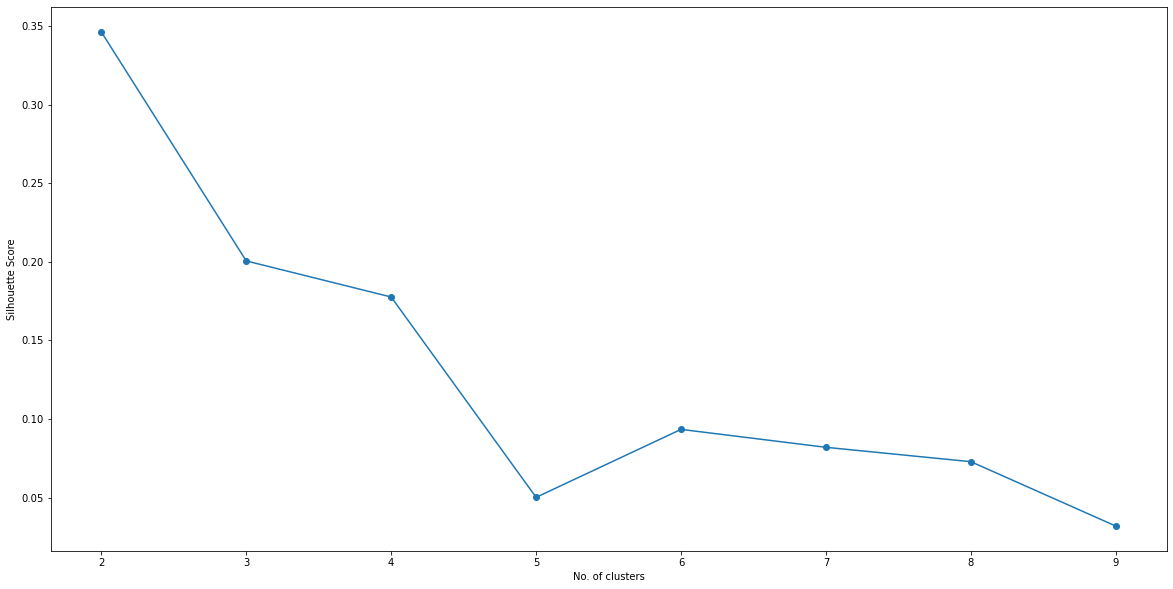

In [357]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [358]:
opt = np.argmax(scores) + 2
print(opt)

2


### K-means for optimal number of clustering

In [359]:
kclusters = opt
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(bucharest_grouped_clustering)

In [360]:
neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)

In [361]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [362]:
neighborhoods_venues_sorted.head()

Cluster Labels   Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0               0   13 Septembrie   Romanian Restaurant     Indian Restaurant   
1               0         Berceni                   Pub   Lebanese Restaurant   
2               0  Bucureștii Noi          Dessert Shop                   Gym   
3               0         Băneasa                  Café            Restaurant   
4               0   Centrul Civic            Restaurant               Theater   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0                 Plaza           Pizza Place      Department Store  
1                Bakery           Cheese Shop              Fountain  
2                Bakery           Supermarket   Fried Chicken Joint  
3                Tunnel      Theme Restaurant           Pizza Place  
4   Romanian Restaurant        Clothing Store        Chocolate Shop

In [363]:
bucharest_merged = df

bucharest_merged = bucharest_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [364]:
print(bucharest_merged['Cluster Labels'].isnull().sum())
bucharest_merged.shape

4


(39, 9)

In [365]:
bucharest_merged.dropna(axis=0, inplace=True)
bucharest_merged.shape

(35, 9)

In [366]:

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lon, poi, cluster in zip(bucharest_merged['Latitude'], bucharest_merged['Longitude'], bucharest_merged['Neighbourhood'], bucharest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [367]:
bucharest_merged.head(10)

Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0         Băneasa  44.493726  26.076048             0.0                  Café   
1         Berceni  44.389221  26.118203             0.0                   Pub   
2  Bucureștii Noi  44.493619  26.031081             0.0          Dessert Shop   
3   Centrul Civic  44.427285  26.092441             0.0            Restaurant   
4       Colentina  44.465766  26.148647             0.0   Rental Car Location   
5       Cotroceni  44.429874  26.070091             0.0                Bistro   
6        Crângași  44.455002  26.047913             0.0         Grocery Store   
7       Dămăroaia  44.491447  26.060160             1.0           Supermarket   
8   Dealul Spirii  44.428385  26.085606             0.0            Art Museum   
9       Dorobanți  44.459076  26.096738             0.0      Sushi Restaurant   

  2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
0            Restaurant                Tunnel             Theme Restaurant   
1   Lebanese Restaurant                Bakery                  Cheese Shop   
2                   Gym                Bakery                  Supermarket   
3               Theater   Romanian Restaurant               Clothing Store   
4                   Spa                 Hotel  Eastern European Restaurant   
5      Pedestrian Plaza                  Park                     Tea Room   
6   Fried Chicken Joint  Gym / Fitness Center                          Gym   
7              Wine Bar   Fried Chicken Joint                 Dessert Shop   
8                   Gym                  Café          Fried Chicken Joint   
9                  Café                Bakery                   Restaurant   

           5th Most Common Venue  
0                    Pizza Place  
1                       Fountain  
2            Fried Chicken Joint  
3                 Chocolate Shop  
4                           Park  
5                         Market  
6                    Pizza Place  
7               Doner Restaurant  
8               Doner Restaurant  
9  Vegetarian / Vegan Restaurant

In [368]:
bucharest_merged['Cluster Labels'].value_counts()

0.0    33
1.0     2
Name: Cluster Labels, dtype: int64

In [369]:
venues0 = bucharest_merged.loc[bucharest_merged['Cluster Labels'] == 0].reset_index().drop(['index'],axis=1)
venues0

Neighbourhood   Latitude  Longitude  Cluster Labels  \
0          Băneasa  44.493726  26.076048             0.0   
1          Berceni  44.389221  26.118203             0.0   
2   Bucureștii Noi  44.493619  26.031081             0.0   
3    Centrul Civic  44.427285  26.092441             0.0   
4        Colentina  44.465766  26.148647             0.0   
5        Cotroceni  44.429874  26.070091             0.0   
6         Crângași  44.455002  26.047913             0.0   
7    Dealul Spirii  44.428385  26.085606             0.0   
8        Dorobanți  44.459076  26.096738             0.0   
9          Dristor  44.418284  26.142541             0.0   
10  Drumul Taberei  44.421340  26.034485             0.0   
11         Dudești  44.422229  26.130392             0.0   
12       Ferentari  44.392845  26.080579             0.0   
13       Floreasca  44.466539  26.102152             0.0   
14         Fundeni  44.463675  26.173474             0.0   
15         Ghencea  44.411369  26.021560             0.0   
16        Giulești  44.453920  26.053113             0.0   
17        Iancului  44.441328  26.133425             0.0   
18        Lipscani  44.432669  26.097680             0.0   
19        Militari  44.435431  26.017106             0.0   
20         Moșilor  44.439542  26.115658             0.0   
21            Obor  44.449757  26.130449             0.0   
22            Odăi  44.391971  26.038861             0.0   
23       Olteniței  44.398580  26.110652             0.0   
24      Primăverii  44.468122  26.089996             0.0   
25           Regie  44.445657  26.053388             0.0   
26     Tineretului  44.413752  26.110802             0.0   
27   13 Septembrie  44.422300  26.070549             0.0   
28      Giurgiului  44.389770  26.093142             0.0   
29             Tei  44.459806  26.118913             0.0   
30           Titan  44.420545  26.158415             0.0   
31       Văcărești  44.404109  26.114987             0.0   
32           Vitan  44.410508  26.129060             0.0   

          1st Most Common Venue        2nd Most Common Venue  \
0                          Café                   Restaurant   
1                           Pub          Lebanese Restaurant   
2                  Dessert Shop                          Gym   
3                    Restaurant                      Theater   
4           Rental Car Location                          Spa   
5                        Bistro             Pedestrian Plaza   
6                 Grocery Store          Fried Chicken Joint   
7                    Art Museum                          Gym   
8              Sushi Restaurant                         Café   
9                   Supermarket                   Restaurant   
10                   Restaurant                Grocery Store   
11                         Café                   Restaurant   
12             Department Store            Food & Drink Shop   
13                         Pool                        Hotel   
14                   Restaurant                          Bar   
15                          Gym           Athletics & Sports   
16                  IT Services                  Pizza Place   
17                  Bus Station  Eastern European Restaurant   
18          Romanian Restaurant                         Café   
19                   Sports Bar                          Gym   
20                 Dessert Shop          Romanian Restaurant   
21          Sporting Goods Shop            Electronics Store   
22  Eastern European Restaurant                     Wine Bar   
23                  Bus Station                 Burger Joint   
24             Greek Restaurant           Italian Restaurant   
25                          Pub                    Nightclub   
26                       Bistro               Tennis Stadium   
27          Romanian Restaurant            Indian Restaurant   
28                   Playground                  Pizza Place   
29                   Restaurant             

In [370]:
venues1 = bucharest_merged.loc[bucharest_merged['Cluster Labels'] == 1].reset_index().drop(['index'],axis=1)
venues1

Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0     Dămăroaia  44.491447  26.060160             1.0           Supermarket   
1    Pantelimon  44.444697  26.170441             1.0           Supermarket   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0              Wine Bar   Fried Chicken Joint          Dessert Shop   
1                  Park           Sports Club              Wine Bar   

  5th Most Common Venue  
0      Doner Restaurant  
1     French Restaurant

In [372]:
venues0.shape

(33, 9)

### Dropping Neighbourhoods that have "Cafe" listed in top 5 Venues

In [373]:
venues0a = venues0[venues0['1st Most Common Venue'] != 'Café']

In [374]:
venues0a = venues0a[venues0a['2nd Most Common Venue'] != 'Café']

In [375]:
venues0a = venues0a[venues0a['3rd Most Common Venue'] != 'Café']

In [376]:
venues0a = venues0a[venues0a['4th Most Common Venue'] != 'Café']

In [377]:
venues0a = venues0a[venues0a['5th Most Common Venue'] != 'Café']

In [378]:
venues0a.shape

(27, 9)

In [379]:
venues0a.head()

Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
1         Berceni  44.389221  26.118203             0.0                   Pub   
2  Bucureștii Noi  44.493619  26.031081             0.0          Dessert Shop   
3   Centrul Civic  44.427285  26.092441             0.0            Restaurant   
4       Colentina  44.465766  26.148647             0.0   Rental Car Location   
5       Cotroceni  44.429874  26.070091             0.0                Bistro   

  2nd Most Common Venue 3rd Most Common Venue        4th Most Common Venue  \
1   Lebanese Restaurant                Bakery                  Cheese Shop   
2                   Gym                Bakery                  Supermarket   
3               Theater   Romanian Restaurant               Clothing Store   
4                   Spa                 Hotel  Eastern European Restaurant   
5      Pedestrian Plaza                  Park                     Tea Room   

  5th Most Common Venue  
1              Fountain  
2   Fried Chicken Joint  
3        Chocolate Shop  
4                  Park  
5                Market

In [380]:
venues0a['1st Most Common Venue'].value_counts()

Restaurant                     5
Bistro                         2
Bus Station                    2
Pub                            2
Gym                            1
Pool                           1
Italian Restaurant             1
Sports Bar                     1
Rental Car Location            1
Supermarket                    1
Romanian Restaurant            1
Sporting Goods Shop            1
Grocery Store                  1
Eastern European Restaurant    1
Playground                     1
Cosmetics Shop                 1
Greek Restaurant               1
IT Services                    1
Dessert Shop                   1
Department Store               1
Name: 1st Most Common Venue, dtype: int64

### Choosing Neighbourhood that has Restaurant as Most Common Venue

In [381]:
venues=venues0a.loc[venues0a['1st Most Common Venue'] == 'Restaurant'].reset_index().drop(['index'],axis=1)
venues

Neighbourhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0   Centrul Civic  44.427285  26.092441             0.0            Restaurant   
1  Drumul Taberei  44.421340  26.034485             0.0            Restaurant   
2         Fundeni  44.463675  26.173474             0.0            Restaurant   
3             Tei  44.459806  26.118913             0.0            Restaurant   
4           Titan  44.420545  26.158415             0.0            Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0               Theater   Romanian Restaurant        Clothing Store   
1         Grocery Store        Farmers Market                  Park   
2                   Bar              Wine Bar   Fried Chicken Joint   
3      Doner Restaurant    Italian Restaurant     Electronics Store   
4                  Park           IT Services          Dessert Shop   

  5th Most Common Venue  
0        Chocolate Shop  
1          Skating Rink  
2          Dessert Shop  
3                   Bar  
4      Doner Restaurant

### Prices/sqm using information from 
https://www.wall-street.ro/articol/Money/233510/imobiliare-ro-pretul-unei-locuinte-in-cartierele-ieftine-din-bucuresti.html

In [382]:
dict={'Neighbourhood':['Kiseleff','Aviatorilor','Herăstrau','Nordului','Dorobanți','Floreasca','Aviației','Unirii','Drumul Taberei','Giurgiului','Giulesti','Rahova','Ghencea'],'Price/sqm':[2580,2580,2410,2410,1990,1990,1870,1720,1050,1040,950,940,940
]}

In [387]:
df_price=pd.DataFrame(dict)
df_price.head()

Neighbourhood  Price/sqm
0      Kiseleff       2580
1   Aviatorilor       2580
2     Herăstrau       2410
3      Nordului       2410
4     Dorobanți       1990

In [388]:
df_price = df_price.join(bucharest_merged.set_index('Neighbourhood'), on='Neighbourhood')

In [389]:
df_price.head(20)

Neighbourhood  Price/sqm   Latitude  Longitude  Cluster Labels  \
0         Kiseleff       2580        NaN        NaN             NaN   
1      Aviatorilor       2580        NaN        NaN             NaN   
2        Herăstrau       2410        NaN        NaN             NaN   
3         Nordului       2410        NaN        NaN             NaN   
4        Dorobanți       1990  44.459076  26.096738             0.0   
5        Floreasca       1990  44.466539  26.102152             0.0   
6         Aviației       1870        NaN        NaN             NaN   
7           Unirii       1720        NaN        NaN             NaN   
8   Drumul Taberei       1050  44.421340  26.034485             0.0   
9       Giurgiului       1040  44.389770  26.093142             0.0   
10        Giulesti        950        NaN        NaN             NaN   
11          Rahova        940        NaN        NaN             NaN   
12         Ghencea        940  44.411369  26.021560             0.0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                    NaN                   NaN                   NaN   
1                    NaN                   NaN                   NaN   
2                    NaN                   NaN                   NaN   
3                    NaN                   NaN                   NaN   
4       Sushi Restaurant                  Café                Bakery   
5                   Pool                 Hotel     French Restaurant   
6                    NaN                   NaN                   NaN   
7                    NaN                   NaN                   NaN   
8             Restaurant         Grocery Store        Farmers Market   
9             Playground           Pizza Place        Sandwich Place   
10                   NaN                   NaN                   NaN   
11                   NaN                   NaN                   NaN   
12                   Gym    Athletics & Sports                   Pub   

          4th Most Common Venue          5th Most Common Venue  
0                           NaN                            NaN  
1                           NaN                            NaN  
2                           NaN                            NaN  
3                           NaN                            NaN  
4                    Restaurant  Vegetarian / Vegan Restaurant  
5   Eastern European Restaurant                         Lounge  
6                           NaN                            NaN  
7                           NaN                            NaN  
8                          Park                   Skating Rink  
9             Electronics Store                    Supermarket  
10                          NaN                            NaN  
11                          NaN                            NaN  
12                  Supermarket                    Bus Station